In [1]:
import os
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow_hub as hub

In [3]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation,BatchNormalization

In [4]:
import numpy as np
import pandas as pd

In [5]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

In [6]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [7]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [8]:
from tqdm import tqdm
from tabulate import tabulate

In [9]:
data_root = "C:\\Users\\Hammad\\Desktop\\Waqas Project\\Dataset(Final)"
img_size = 15

index_label = {}

# Discover the class label names.
class_labels = os.listdir(data_root)
nclasses = len(class_labels)
X, y, images = [], [], []

for label_index, label in enumerate(class_labels):
    # Load the images for this class label.
    index_label[label_index] = label

    img_names = os.listdir(os.path.join(data_root, label))
    for img_name in img_names:
        img_path = os.path.join(data_root, label, img_name)
        img = load_img(img_path, target_size=(img_size, img_size))
        images.append(img)
        X.append(img_to_array(img))
        y.append(label_index)

X = np.array(X)
y_old = np.array(y)
y = to_categorical(y, num_classes=nclasses)

In [10]:
def plotImages(image_arr):
    fig,axes = plt.subplots(1, 4, figsize=(20,20))
    axes = axes.flatten()
    for img,ax in zip(image_arr,axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

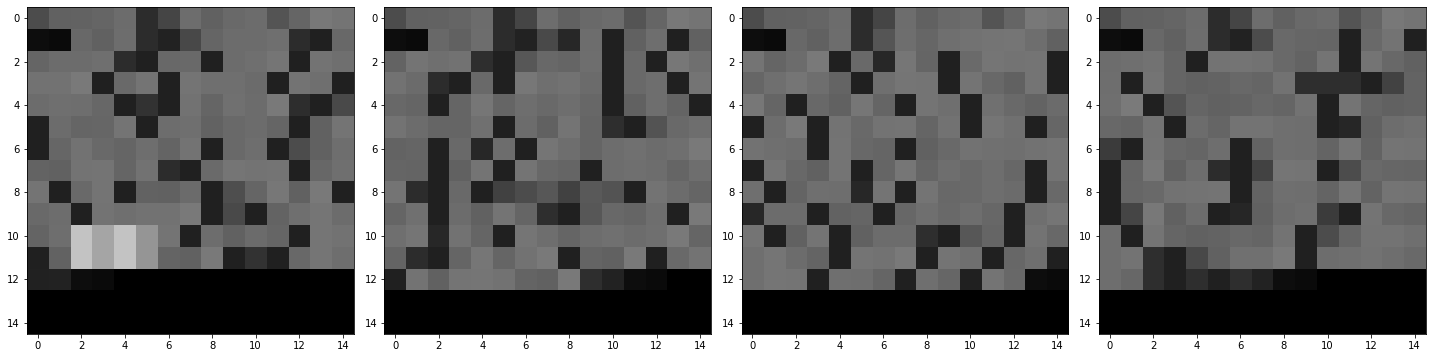

In [11]:
# Plot a few training images
plotImages(images)

In [12]:
print(index_label)

{0: 'Ham', 1: 'Spam'}


In [13]:
print(X.shape)
print(y.shape)

(71, 15, 15, 3)
(71, 2)


In [15]:
# reshape dataset to have a single channel
trainX = X.reshape((X.shape[0], 15, 15, 3))
trainY = y
print(trainX.shape)
print(trainY.shape)

(71, 15, 15, 3)
(71, 2)


In [16]:
#Define Model
model = Sequential()
model.add(Conv2D(8, (3,3), input_shape=(15,15,3), kernel_initializer='he_uniform', activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(16, (3,3), kernel_initializer='he_uniform', activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(100,activation="relu"))
model.add(Dense(2, activation="softmax"))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 16)          1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [23]:
from keras.layers import MaxPool2D
from tensorflow.keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Reshape

X = trainX
y = trainY
labels = y_old
train_accs, test_accs = [], []
history = []
verbose = True
i = 0

# Train and evaluate the model for each fold.
for train_index, test_index in tqdm(
    RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, random_state=0
    ).split(X, labels),
    total=10*3, disable = not True #(verbose - True)
):

    # Select the data for this fold.
    X_train = tf.gather(X, train_index) 
    y_train = tf.gather(y, train_index)
    X_test = tf.gather(X, test_index)
    y_test = tf.gather(y, test_index)

    if (i==0):
        i=1
        print(X_train.shape)
        print(X_test.shape)
        print(y_train.shape)
        print(y_test.shape)
    
    #Define Model
    #Define Model
    model = Sequential()
    model.add(Conv2D(8, (3,3), input_shape=(15,15,3), kernel_initializer='he_uniform', activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(16, (3,3), kernel_initializer='he_uniform', activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(100,activation="relu"))
    model.add(Dense(2, activation="softmax"))

    #Learning Rate
    steps_per_epoch = math.ceil(len(X_train) / 32) #batch - 32
    third_of_total_steps = math.floor(10 * steps_per_epoch / 3) #epoch - 10
    
    # Train and evaluate the model.
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                0.0003,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the test set.
    history = (model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0, validation_data=(X_test, y_test)))
    train_loss, train_acc = model.evaluate(X_train, y_train, batch_size=32, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

# Report.
if verbose:
    print(
        tabulate(
            [
                ["Train", results["Train_Acc"], results["Train_std"]],
                ["Test", results["Test_Acc"], results["Test_std"]]
            ],
            headers=["Set", "Accuracy", "Standard Deviation"]
        )
    )

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

(63, 15, 15, 3)
(8, 15, 15, 3)
(63, 2)
(8, 2)


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:34<00:00,  1.16s/it]

Set      Accuracy    Standard Deviation
-----  ----------  --------------------
Train    0.537814              0.100355
Test     0.48869               0.153992


In [24]:
model.summary()

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 13, 13, 8)         224       
_________________________________________________________________
max_pooling2d_180 (MaxPoolin (None, 6, 6, 8)           0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 4, 4, 16)          1168      
_________________________________________________________________
max_pooling2d_181 (MaxPoolin (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_90 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_180 (Dense)            (None, 100)               6500      
_________________________________________________________________
dense_181 (Dense)            (None, 2)               

In [25]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy value (%)')
    plt.xlabel('No. epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend()

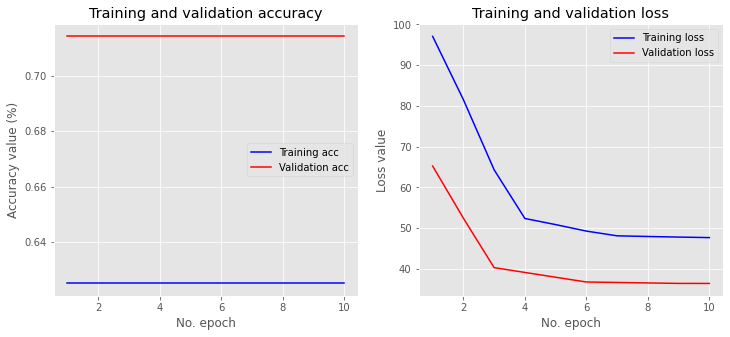

In [26]:
plot_history(history)

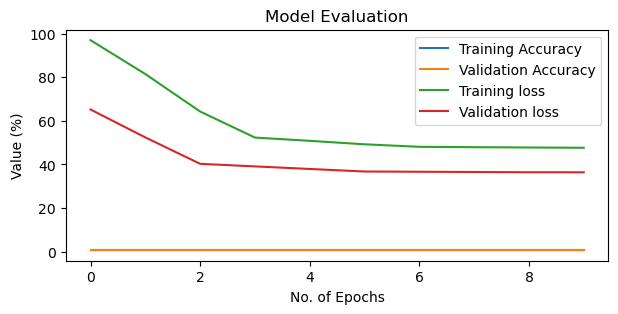

In [27]:
#All in one Graph (loss and accuracy)
plt.style.use('default')
plt.figure(figsize=(7, 3))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"]) 
plt.title("Model Evaluation")
plt.ylabel("Value (%)")
plt.xlabel("No. of Epochs")
plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation loss"])
plt.show()

In [28]:
# save model
model.save('waqas_new1.h5')

In [71]:
#Mnist Model that is working with symblic Eqecution
#Define Model
model = Sequential()
model.add(Conv2D(8, (3,3), input_shape=(28,28,1), kernel_initializer='he_uniform', activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(16, (3,3), kernel_initializer='he_uniform', activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(100,activation="relu"))
model.add(Dense(10, activation="softmax"))

In [72]:
model.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_190 (Conv2D)          (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_190 (MaxPoolin (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_191 (MaxPoolin (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_52 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_138 (Dense)            (None, 100)               40100     
_________________________________________________________________
dense_139 (Dense)            (None, 10)              